# Анализ трафика интернет магазина

Перед тобой датасет (https://drive.google.com/file/d/16llNk3bEYLaS4ReJ8PBrXQFEehqOPf44/view) некой интернет-компании. Загрузи его в Python или R, ознакомься с
данными и ответь на приведенные ниже вопросы. Для ответа на некоторые из них
понадобится произвести расчеты, ход которых опиши в файле с кодом.

a. Какой рекламный канал принёс больше всего дохода за всё время?

b. Как изменился средний чек транзакции после введения коронавирусных ограничений?
Как он изменился для пользователей, покупающих с промокодом и без? (параметр
«promo_activated»)

c. Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в
транзакцию) в выходные дни отличается от CR в будние дни?

d. Вам необходимо спрогнозировать объем дохода, полученного с пользователей,
приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед.
Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам
понадобятся?

---

### Начало

Подключим необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm.notebook import tqdm

plt.style.use('ggplot')
%matplotlib inline

Загрузим исправленный файл и посмотрим на данные из него.

In [3]:
data_6 = pd.read_csv('summer_camp_data.csv')
data_6.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0


In [4]:
data_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52724 entries, 0 to 52723
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                52724 non-null  object 
 1   source              52724 non-null  object 
 2   medium              52724 non-null  object 
 3   delivery_available  52724 non-null  object 
 4   device_type         52724 non-null  object 
 5   promo_activated     52724 non-null  object 
 6   filter_used         52724 non-null  object 
 7   pageviews           52724 non-null  int64  
 8   visits              52724 non-null  int64  
 9   productClick        52724 non-null  int64  
 10  addToCart           52724 non-null  int64  
 11  checkout            52724 non-null  int64  
 12  transactions        52724 non-null  int64  
 13  revenue             52724 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 5.6+ MB


In [199]:
data_6["device_type"].value_counts()

device_type
Мобайл           24419
Десктоп          22919
Не определено     5386
Name: count, dtype: int64

Так надо бы сделать тип данный date для столбца date

In [5]:
data_6["date"].head(2)

0    2020-05-11
1    2020-05-11
Name: date, dtype: object

In [6]:
data_6["date"] = pd.to_datetime(data_6["date"], format="%Y-%m-%d")

In [7]:
data_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52724 entries, 0 to 52723
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                52724 non-null  datetime64[ns]
 1   source              52724 non-null  object        
 2   medium              52724 non-null  object        
 3   delivery_available  52724 non-null  object        
 4   device_type         52724 non-null  object        
 5   promo_activated     52724 non-null  object        
 6   filter_used         52724 non-null  object        
 7   pageviews           52724 non-null  int64         
 8   visits              52724 non-null  int64         
 9   productClick        52724 non-null  int64         
 10  addToCart           52724 non-null  int64         
 11  checkout            52724 non-null  int64         
 12  transactions        52724 non-null  int64         
 13  revenue             52724 non-null  float64   

### a. Какой рекламный канал принёс больше всего дохода за всё время?

Посмотрим на источники пользователей и рекламные кампании

In [8]:
pd.DataFrame(data_6["source"].value_counts()).T

source,yandex,google,(direct),admitad,eLama,cityads,other,newsletter,vk,promo,...,actionpay,opmcpa,mytarget,advertise,instagram,yandex_direct,youtube,sailplay,baidu,exponea
count,11929,11794,5032,4210,3415,2923,2460,1680,1425,1178,...,763,545,540,327,301,109,88,49,19,19


In [9]:
data_6["medium"].value_counts()

medium
cpc        16835
organic    15520
cpa         8927
(none)      5032
email       3998
social      2412
Name: count, dtype: int64

Итак, из данных видно, что у нас есть список сайтов, с которых пользователи переходят в наш магазин (источники пользователей), а также 5 видов рекламных кампаний (средства получения пользователей). Теперь посмотрим на выручку по каждому направлению

In [10]:
rev_sources_data = data_6.groupby("source")["revenue"].sum().sort_values(ascending=False)
sources = rev_sources_data.index
rev_sources = rev_sources_data.values

sources_10 = sources[:10]
rev_sources_10 = rev_sources[:10]

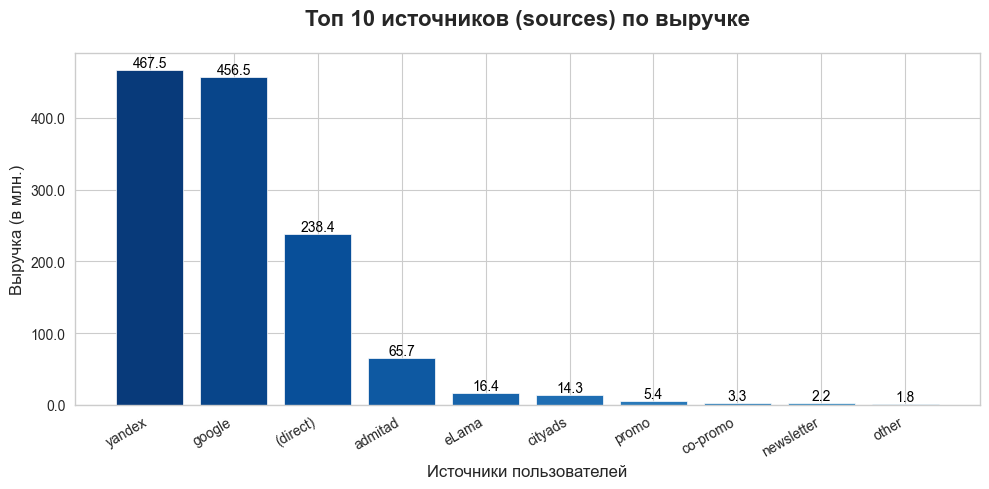

In [11]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

bars = plt.bar(x=sources_10, height=rev_sources_10, color=sns.color_palette("Blues_r", len(sources)))

plt.title("Топ 10 источников (sources) по выручке", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Источники пользователей", fontsize=12)
plt.ylabel("Выручка (в млн.)", fontsize=12)

plt.xticks(rotation=30, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height/1e6:.1f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [12]:
rev_medium_data = data_6.groupby("medium")["revenue"].sum().sort_values(ascending=False)
medium = rev_medium_data.index
rev_medium = rev_medium_data.values

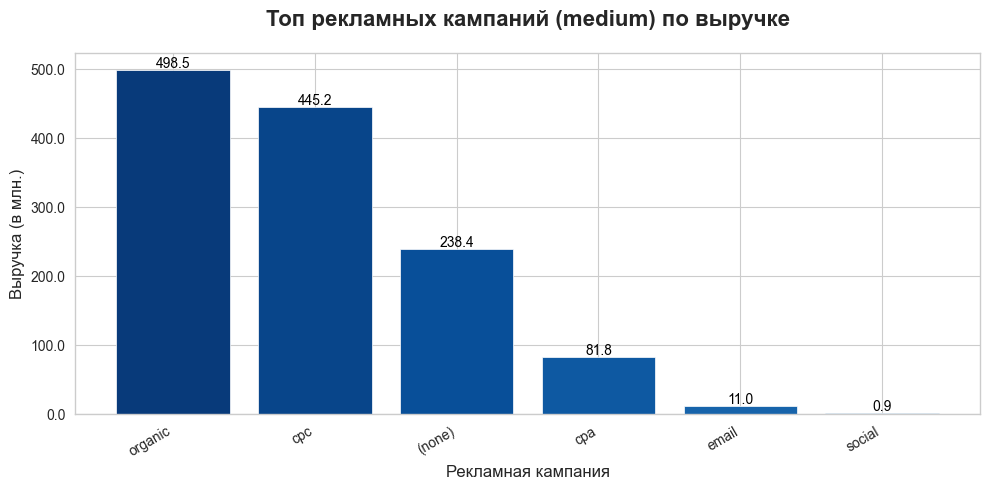

In [13]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

bars = plt.bar(x=medium, height=rev_medium, color=sns.color_palette("Blues_r", len(sources)))

plt.title("Топ рекламных кампаний (medium) по выручке", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Рекламная кампания", fontsize=12)
plt.ylabel("Выручка (в млн.)", fontsize=12)

plt.xticks(rotation=30, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height/1e6:.1f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

Итак, видно, что __первый по выручке__ источник появления пользователей - это __Yandex__, на __втором__ месте идёт __Google__ с небольших отрывом, а дальше уже идёт прямое подключение пользователей по ссылке магазина (__direct__), причём разрыв между 2 и 3 метами большой. 

Если же говорить не про источники по которым переходят пользователи в магазин, а именно про рекламные кампании, то видно, что в __основном__ магазин получает пользователей __естественным путём__, то есть пользователи приходят на сайт самостоятельно через результаты поиска в поисковых системах (Google, Яндекс и т.д.). Пользователи находят сайт, вводя запросы, и переходят по ссылкам из выдачи без участия платной рекламы. На __следующем месте__ с небольшим отрывом идёт платный трафик, приходящий через контекстную рекламу с оплатой за клик (__cpc__). Например, контекстная реклама в Google Ads или Яндекс.Директ . Пользователи кликают по рекламным объявлениям, и за каждый клик рекламодатель платит определённую сумму. На __третьем же месте__ находится трафик, который связан с прямыми переходами (__direct__) пользователей на сайт (это в частности видно из того, что выручки для direct и (none) совпадают).

### b. Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

Теперь же проанализируем как изменился средний чек транзакции после введения коронавирусных ограничений. Будем считать, что пик коронавирусных ограничений в России приходился на конец марта 2020 (30 марта) по середину мая 2020 (11 мая), так именно эти дни были объявлены нерабочими в России.

Но для начала посчитаем средний чек транзакций по месяцам.

In [14]:
month_dict = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель',
    5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август',
    9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
}

data_6 = data_6.assign(month = lambda x: x.date.dt.month)
data_6.head(3)

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,month
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,5
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,5
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,5


In [15]:
aov_month = data_6.groupby("month")["revenue"].sum() / data_6.groupby("month")["transactions"].sum().sort_index()
aov_month_date = aov_month.index
aov_month_value = aov_month.values

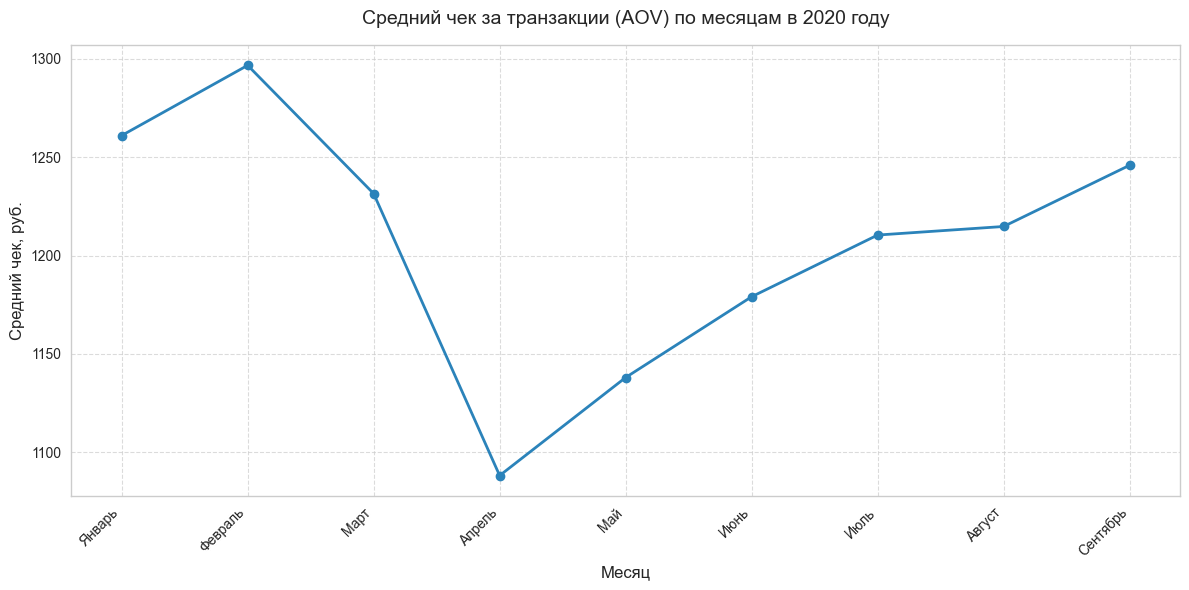

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(aov_month_date, aov_month_value, 
         marker='o',
         linestyle='-',
         color='#2b83ba',
         linewidth=2)

plt.xticks(range(1, 10), [month_dict[i] for i in range(1, 10)], 
          rotation=45,
          ha='right')

plt.title('Средний чек за транзакции (AOV) по месяцам в 2020 году', fontsize=14, pad=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Средний чек, руб.', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

Видно __сильное падение__ в апреле 2020 года, связанное с ограничительными мерами в пике, и постепенное восстановление, которое не достигло прежних показателей к октябрю 2020 года.

Теперь построим график по дням, чтобы получить больше информации по коронавирусному кризису, а точнее по его влиянию на интернет магазин.

In [17]:
aov_day = data_6.groupby("date")["revenue"].sum() / data_6.groupby("date")["transactions"].sum()
aov_day_date = aov_day.index
aov_day_value = aov_day.values

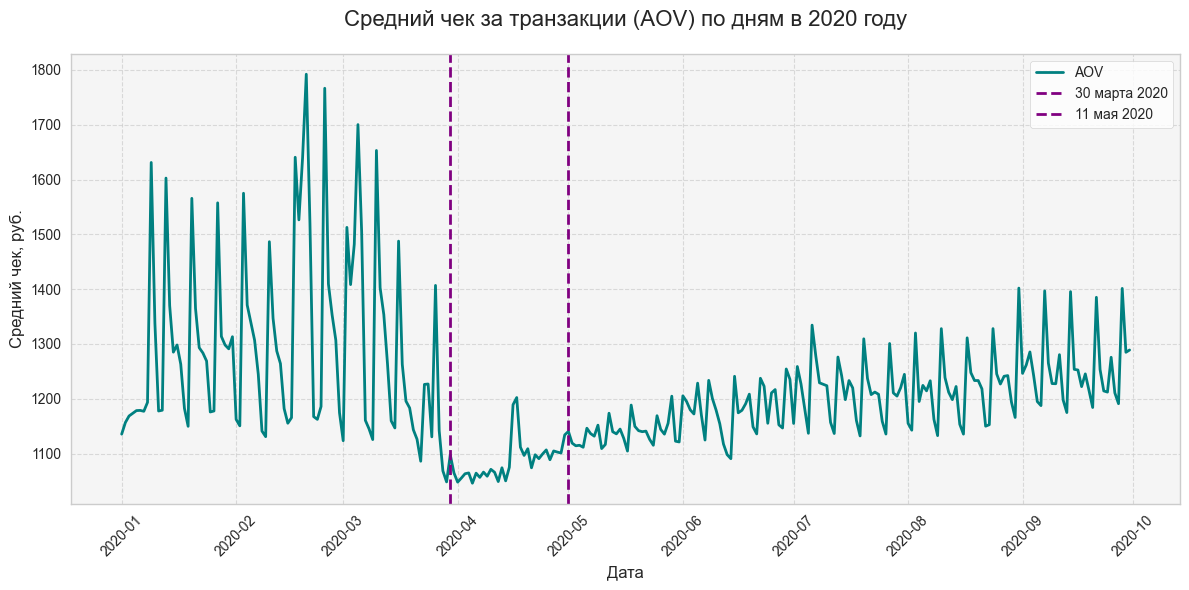

In [36]:
from datetime import datetime

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(aov_day_date, aov_day_value, color='teal', linewidth=2, label='AOV')
plt.axvline(x=datetime(2020, 3, 30), color='purple', linestyle='--', linewidth=2, label='30 марта 2020')
plt.axvline(x=datetime(2020, 5, 1), color='purple', linestyle='--', linewidth=2, label='11 мая 2020')

plt.title('Средний чек за транзакции (AOV) по дням в 2020 году', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средний чек, руб.', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()

Видно, что в период пика ограничений средний чек __сильно упал__. Причём интересно заметить, что если до 30 марта средний чек __был периодичен__ в течение недели (в будни меньше к выходным больше), то в период коронавирусных ограничений он __такую специфику потерял__ и стал почти гладким, то есть у людей выходные сравнялись с будними днями. 

Ну, а после 11 мая наблюдается восстановление периодичности среднего чека, но прежних показателей даже к октябрю 2020 года он всё равно __не достигает__. Это связано с тем, что некоторые ограничения продолжали сохраняться вплоть до конца 2021 года. Хотя ещё интереснее заметить, что минимальный средний чек за неделю (в будний день) примерно достигает показателей до ковидных, а вот максимум среднего чека (в выходной день) - нет. 

Теперь проведём тот же анализ, но уже для пользователей, покупающих с промокодом или без него.

In [32]:
aov_month_promo = data_6[data_6.promo_activated == 'yes'].groupby("month")["revenue"].sum() / data_6[data_6.promo_activated == 'yes'].groupby("month")["transactions"].sum().sort_index()
aov_month_no_promo = data_6[data_6.promo_activated == 'no'].groupby("month")["revenue"].sum() / data_6[data_6.promo_activated == 'no'].groupby("month")["transactions"].sum().sort_index()


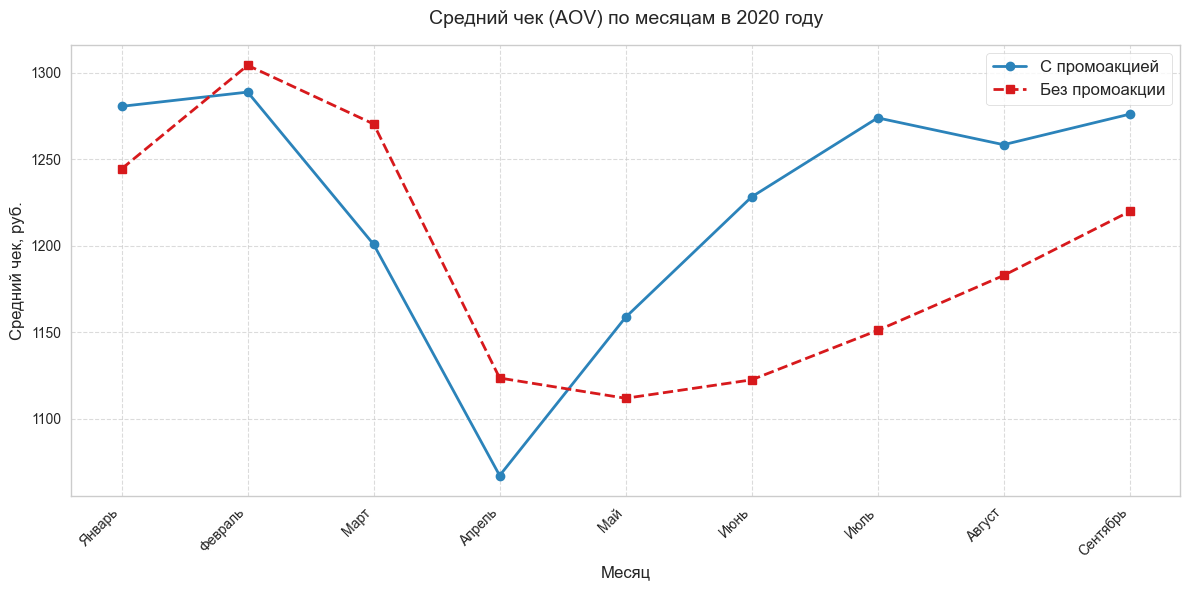

In [40]:
plt.figure(figsize=(12, 6))

plt.plot(aov_month_promo.index, aov_month_promo.values, 
         marker='o',
         linestyle='-',
         color='#2b83ba',
         linewidth=2,
         label='С промоакцией')

plt.plot(aov_month_no_promo.index, aov_month_no_promo.values, 
         marker='s',
         linestyle='--',
         color='#d7191c',
         linewidth=2,
         label='Без промоакции')
plt.xticks(range(1, 10), [month_dict[i] for i in range(1, 10)], 
          rotation=45,
          ha='right')

plt.title('Средний чек (AOV) по месяцам в 2020 году', fontsize=14, pad=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Средний чек, руб.', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='best')

plt.tight_layout()

plt.show()

Падение, понятное дело, всё также наблюдается, но теперь видно, что средний чек для пользователей с промоакциям увеличивается сильно быстрее, чем для пользователей, которые не использовали промо. Причём промо помогает практически достигнуть показателей схожих с доковидными. Хотя именно в сам ковид средний чек пользователей с промо был даже меньше, чем у пользователей без промо (видимо просто магазин сократил количество промоакций).

In [34]:
aov_day_promo = data_6[data_6.promo_activated == 'yes'].groupby("date")["revenue"].sum() / data_6[data_6.promo_activated == 'yes'].groupby("date")["transactions"].sum()
aov_day_no_promo = data_6[data_6.promo_activated == 'no'].groupby("date")["revenue"].sum() / data_6[data_6.promo_activated == 'no'].groupby("date")["transactions"].sum()

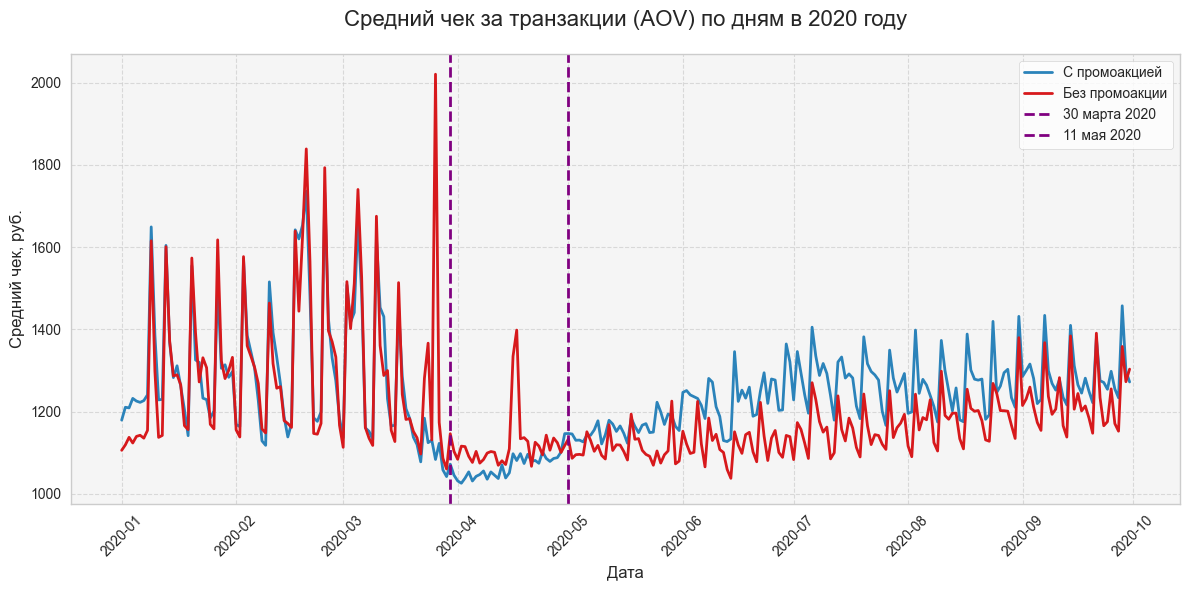

In [39]:
from datetime import datetime

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(aov_day_promo.index, aov_day_promo.values, 
         color='#2b83ba',
         linewidth=2,
         label='С промоакцией')

plt.plot(aov_day_no_promo.index, aov_day_no_promo.values, 
         color='#d7191c',
         linewidth=2,
         label='Без промоакции')

plt.axvline(x=datetime(2020, 3, 30), color='purple', linestyle='--', linewidth=2, label='30 марта 2020')
plt.axvline(x=datetime(2020, 5, 1), color='purple', linestyle='--', linewidth=2, label='11 мая 2020')

plt.title('Средний чек за транзакции (AOV) по дням в 2020 году', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средний чек, руб.', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()

В целом здесь видны те же закономерности, ну и её специфика периодичности по неделям.

### c. Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?

На предыдущих графиках для среднего чека по дням мы заметили некоторую периодичность по неделям. 

Теперь же проверим гипотезу, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни и проверим, что в выходные дни он больше. Правда на предыдущем этапе мы выявили проблему (ковидные ограничения), из-за которой, если мы проведём тест на генеральной совокупности, то у нас вывод может получиться некорректным. Так что проведём сразу 2 теста: гипотеза до ковидных ограничений, гипотеза после и во время ковидных ограничений.

#### До ковида

Считаем CR из productClick в transactions за день и отметим выходные дни

In [132]:
data_pred_cov = data_6[data_6.month <= 3]

In [133]:
data_pred_cov = data_pred_cov.copy()
data_pred_cov["weekend"] = data_pred_cov["date"].apply(lambda x: x.weekday() in [5, 6])
data_pred_cov.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,month,weekend
12,2020-03-26,(direct),(none),Доставка есть,Мобайл,yes,no,224,16,520,104,80,14,14488.0,3,False
13,2020-03-26,(direct),(none),Не определено,Мобайл,yes,no,1914,377,5220,1044,719,95,97904.0,3,False
14,2020-03-26,(direct),(none),Не определено,Мобайл,no,no,2329,1491,2130,426,220,37,34204.0,3,False
15,2020-03-26,google,organic,Не определено,Мобайл,yes,no,4761,794,11890,2378,1722,278,266796.0,3,False
16,2020-03-26,admitad,cpa,Не определено,Мобайл,yes,no,909,172,2080,416,308,39,37693.0,3,False


Построим график CR и точками на нём отметим выходные и будние дни

In [134]:
weekend_pred_cov = data_pred_cov[data_pred_cov.weekend]
weekday_pred_cov = data_pred_cov[~data_pred_cov.weekend]

In [135]:
CR_pred_cov = data_pred_cov.groupby("date")["transactions"].sum() / data_pred_cov.groupby("date")["productClick"].sum()
CR_weekend_pred_cov = weekend_pred_cov.groupby("date")["transactions"].sum() / weekend_pred_cov.groupby("date")["productClick"].sum()
CR_weekday_pred_cov = weekday_pred_cov.groupby("date")["transactions"].sum() / weekday_pred_cov.groupby("date")["productClick"].sum()

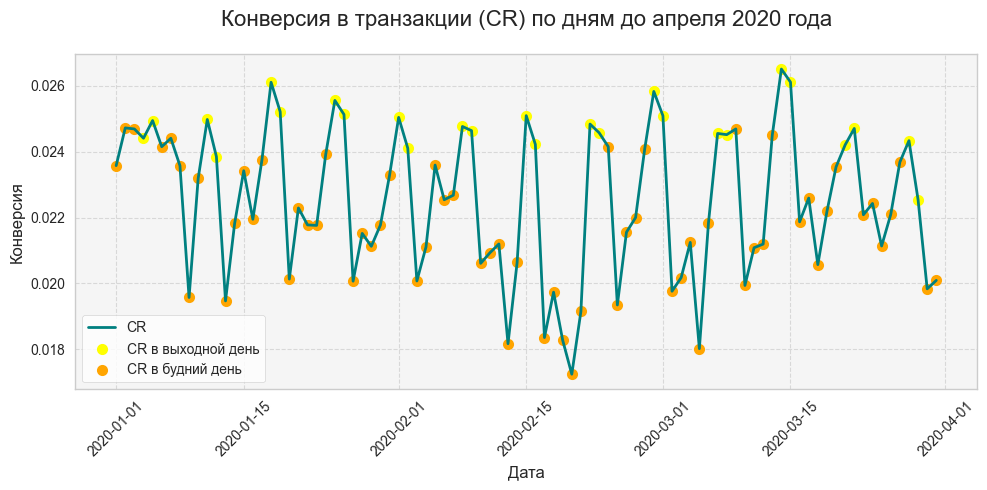

In [136]:
from datetime import datetime

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(CR_pred_cov.index, CR_pred_cov.values, color='teal', linewidth=2, label='CR')
plt.scatter(CR_weekend_pred_cov.index, CR_weekend_pred_cov.values, color='yellow', linewidth=2, label='CR в выходной день')
plt.scatter(CR_weekday_pred_cov.index, CR_weekday_pred_cov.values, color='orange', linewidth=2, label='CR в будний день')

plt.title('Конверсия в транзакции (CR) по дням до апреля 2020 года', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()

Для начала посмотрим какого размера должны быть выборки, чтобы задетектировать определённый MDE, при условии, что alpha = 5%, а мощность = 80%

In [190]:
from scipy import stats
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power, NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.meta_analysis import effectsize_smd


from typing import Union

def calc_propotion_effect_size(conv1: int, nobs1: int, conv2: int, nobs2: int):
    p1, p2 = conv1 / nobs1, conv2 / nobs2
    return proportion_effectsize(p1, p2)

def calc_sample_size_proportion(effect_size: float,
                                alpha: float = .05,
                                beta: float = .2,
                                ratio: Union[float, int] = 1):
    n = zt_ind_solve_power(effect_size=effect_size,
                           alpha=alpha,
                           power=(1 - beta),
                           ratio=ratio,
                  )
    return int(n)

In [189]:
alpha = .05
beta = .2

na = weekday_pred_cov["productClick"].sum()
nb = weekend_pred_cov["productClick"].sum()

ma = weekday_pred_cov["transactions"].sum()
mb = weekend_pred_cov["transactions"].sum()

print(f"Размер выборок A/B: {na, nb}")

Размер выборок A/B: (np.int64(10167220), np.int64(5577230))


In [195]:
effect_size = calc_propotion_effect_size(ma, na, mb, nb)

n = calc_sample_size_proportion(effect_size = abs(effect_size), alpha = alpha, beta = beta, ratio = 1)
print(f"Размер одной из группы в пользователях должен быть = {n}")

power_analysis = NormalIndPower()
power = power_analysis.power(effect_size=abs(effect_size), nobs1=na, alpha=alpha, ratio=1, alternative='two-sided')
print(f"Мощность двустороннего теста: {power}")

power_analysis = NormalIndPower()
power = power_analysis.power(effect_size=abs(effect_size), nobs1=na, alpha=alpha, ratio=1, alternative='larger')
print(f"Мощность двустороннего теста: {power}")

Размер одной из группы в пользователях должен быть = 34252
Мощность двустороннего теста: 1.0
Мощность двустороннего теста: 1.0


Таким образом, обладает требуемой стат. значимостью и мощностью 

Теперь проведём обычный z-тест для конверсии, чтобы проверить гипотезы

$H_0: CR_{weekend} = CR_{weekday}$

$H_1: CR_{weekend} \neq CR_{weekday}$

In [137]:
def test_cr_two_sided(alpha, na, nb, ma, mb):
    '''
    Выдаёт: 
    True - отвергаем H_0
    False - принимаем H_0
    '''
    wa = ma / na
    wb = mb / nb
    w0 = (ma + mb) / (na + nb)
    Stat = (wb - wa) / (np.sqrt(w0 * (1 - w0) * (1/na + 1/nb)))
    norm_distr = stats.norm(loc=0, scale=1)
    p_value = 2 * min(norm_distr.sf(Stat), norm_distr.cdf(Stat))
    if p_value > alpha:
        return False
    return True

In [156]:
ret = test_cr_two_sided(alpha, na, nb, ma, mb)
print("Таким образом, получаем:")
print("CR_weekend != CR_weekday") if ret else print("CR_weekend == CR_weekday")

Таким образом, получаем:
CR_weekend != CR_weekday


Теперь проверим одностороннюю гипотезу с использованием доверительного интервала:

$H_0: CR_{weekend} = CR_{weekday}$

$H_1: CR_{weekend} > CR_{weekday}$

In [139]:
from statsmodels.stats.proportion import proportion_confint
def test_cr_one_sided(alpha, na, nb, ma, mb):
    '''
    Выдаёт: 
    True - отвергаем H_0
    False - принимаем H_0
    '''
    wa = ma / na
    wb = mb / nb
    w0 = (ma + mb) / (na + nb)
    diff = wb - wa
    Stat = (diff) / (np.sqrt(w0 * (1 - w0) * (1/na + 1/nb)))
    norm_distr = stats.norm(loc=0, scale=1)
    p_value = norm_distr.sf(Stat)
    SE = np.sqrt(w0 * (1-w0) * (1/na + 1/nb))
    quantile = norm_distr.ppf(alpha/2)
    CI = (diff + SE * quantile, diff -SE * quantile)
    
    if p_value > alpha:
        return False
    elif CI[0] > 0 or CI[1] < 0:
        return True
    else:
        return False

In [143]:
ret = test_cr_one_sided(alpha, na, nb, ma, mb)
print("Таким образом, получаем:")
print("CR_weekend > CR_weekday") if ret else print("CR_weekend == CR_weekday")

Таким образом, получаем:
CR_weekend > CR_weekday


Таким образом, мы получили, что CR по выходным дням был выше, чем CR по будним дням до ковида

#### После кодида

Проделываем всё тот же анализ

In [144]:
data_post_cov = data_6[data_6.month > 3]

In [145]:
data_post_cov = data_post_cov.copy()
data_post_cov["weekend"] = data_post_cov["date"].apply(lambda x: x.weekday() in [5, 6])
data_post_cov.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,month,weekend
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,5,False
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,5,False
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,5,False
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,5,False
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,5,False


In [149]:
weekend_post_cov = data_post_cov[data_post_cov.weekend]
weekday_post_cov = data_post_cov[~data_post_cov.weekend]

In [150]:
CR_post_cov = data_post_cov.groupby("date")["transactions"].sum() / data_post_cov.groupby("date")["productClick"].sum()
CR_weekend_post_cov = weekend_post_cov.groupby("date")["transactions"].sum() / weekend_post_cov.groupby("date")["productClick"].sum()
CR_weekday_post_cov = weekday_post_cov.groupby("date")["transactions"].sum() / weekday_post_cov.groupby("date")["productClick"].sum()

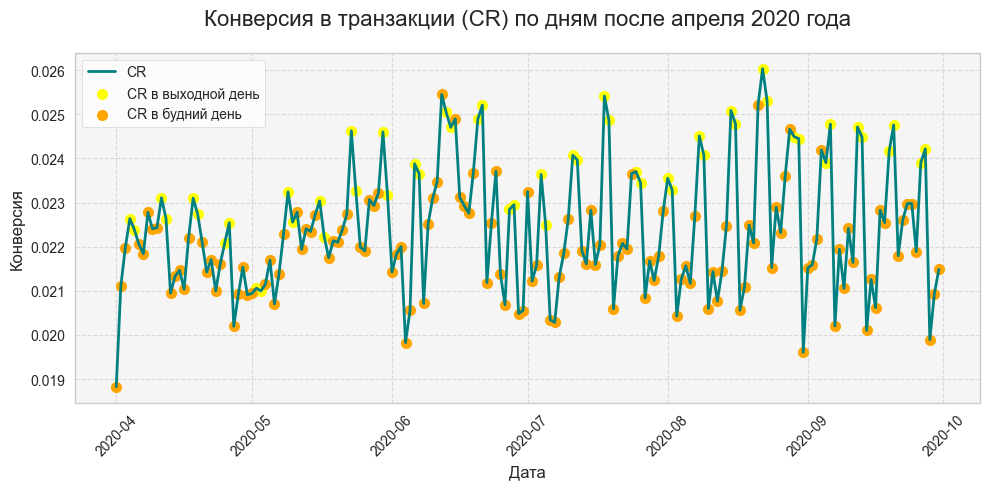

In [151]:
from datetime import datetime

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(CR_post_cov.index, CR_post_cov.values, color='teal', linewidth=2, label='CR')
plt.scatter(CR_weekend_post_cov.index, CR_weekend_post_cov.values, color='yellow', linewidth=2, label='CR в выходной день')
plt.scatter(CR_weekday_post_cov.index, CR_weekday_post_cov.values, color='orange', linewidth=2, label='CR в будний день')

plt.title('Конверсия в транзакции (CR) по дням после апреля 2020 года', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()

In [196]:
alpha = .05
beta = .2

na = weekday_post_cov["productClick"].sum()
nb = weekend_post_cov["productClick"].sum()

ma = weekday_post_cov["transactions"].sum()
mb = weekend_post_cov["transactions"].sum()

print(f"Размер выборок A/B: {na, nb}")

Размер выборок A/B: (np.int64(21533040), np.int64(9704180))


In [197]:
effect_size = calc_propotion_effect_size(ma, na, mb, nb)

n = calc_sample_size_proportion(effect_size = abs(effect_size), alpha = alpha, beta = beta, ratio = 1)
print(f"Размер одной из группы в пользователях должен быть = {n}")

power_analysis = NormalIndPower()
power = power_analysis.power(effect_size=abs(effect_size), nobs1=na, alpha=alpha, ratio=1, alternative='two-sided')
print(f"Мощность двустороннего теста: {power}")

power_analysis = NormalIndPower()
power = power_analysis.power(effect_size=abs(effect_size), nobs1=na, alpha=alpha, ratio=1, alternative='larger')
print(f"Мощность двустороннего теста: {power}")

Размер одной из группы в пользователях должен быть = 110352
Мощность двустороннего теста: 1.0
Мощность двустороннего теста: 1.0


Таким образом, обладает требуемой стат. значимостью и мощностью 

$H_0: CR_{weekend} = CR_{weekday}$

$H_1: CR_{weekend} \neq CR_{weekday}$

In [152]:
alpha = .05

na = weekday_post_cov["productClick"].sum()
nb = weekend_post_cov["productClick"].sum()

ma = weekday_post_cov["transactions"].sum()
mb = weekend_post_cov["transactions"].sum()

ret = test_cr_two_sided(alpha, na, nb, ma, mb)
print("Таким образом получаем:")
print("CR_weekend != CR_weekday") if ret else print("CR_weekend == CR_weekday")

Таким образом получаем:
CR_weekend != CR_weekday


$H_0: CR_{weekend} = CR_{weekday}$

$H_1: CR_{weekend} > CR_{weekday}$

In [153]:
ret = test_cr_one_sided(alpha, na, nb, ma, mb)
print("Таким образом, получаем:")
print("CR_weekend > CR_weekday") if ret else print("CR_weekend == CR_weekday")

Таким образом, получаем:
CR_weekend > CR_weekday


Таким образом, мы получили, что CR по выходным дням был выше, чем CR по будним дням даже после начала ковидных ограничений

### d. Необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. Описать, как подойти к этой задаче и какие дополнительные данные понадобятся?

Для начала просто посмотрим выручку для контекстной рекламы по дням и по месяцам, как мы делали для среднего чека

In [200]:
data_cpc = data_6[data_6["medium"] == "cpc"]

In [204]:
cpc_rev_day = data_cpc.groupby("date")["revenue"].sum().sort_index()
cpc_rev_month = data_cpc.groupby("month")["revenue"].sum().sort_index()

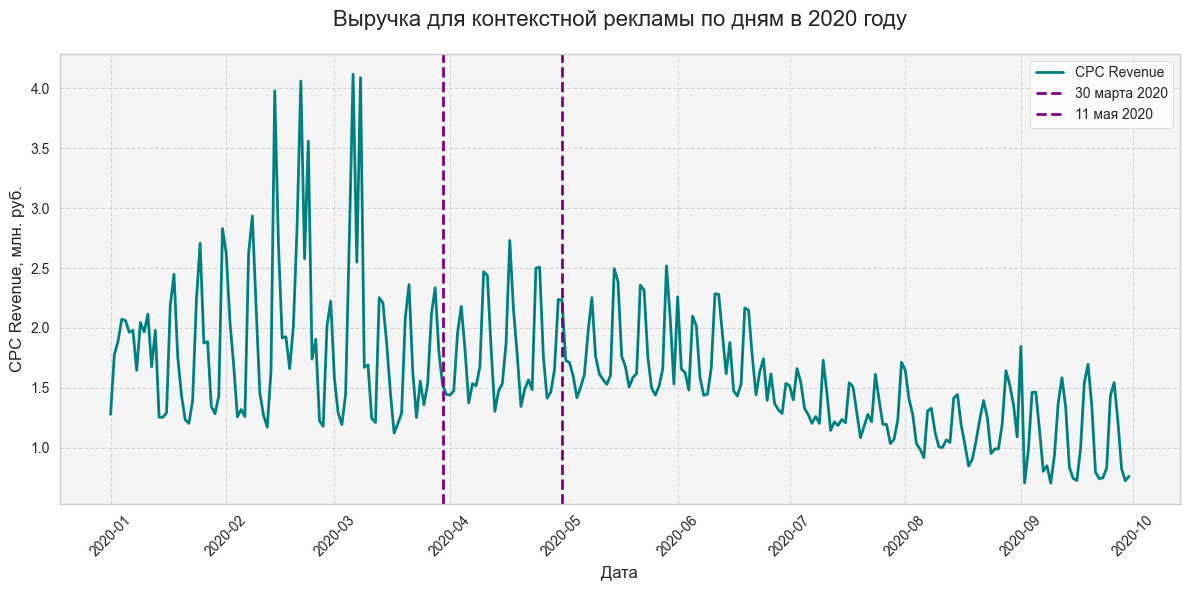

In [208]:
from datetime import datetime

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(cpc_rev_day.index, cpc_rev_day.values, color='teal', linewidth=2, label='CPC Revenue')
plt.axvline(x=datetime(2020, 3, 30), color='purple', linestyle='--', linewidth=2, label='30 марта 2020')
plt.axvline(x=datetime(2020, 5, 1), color='purple', linestyle='--', linewidth=2, label='11 мая 2020')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

plt.title('Выручка для контекстной рекламы по дням в 2020 году', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('CPC Revenue, млн. руб.', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()

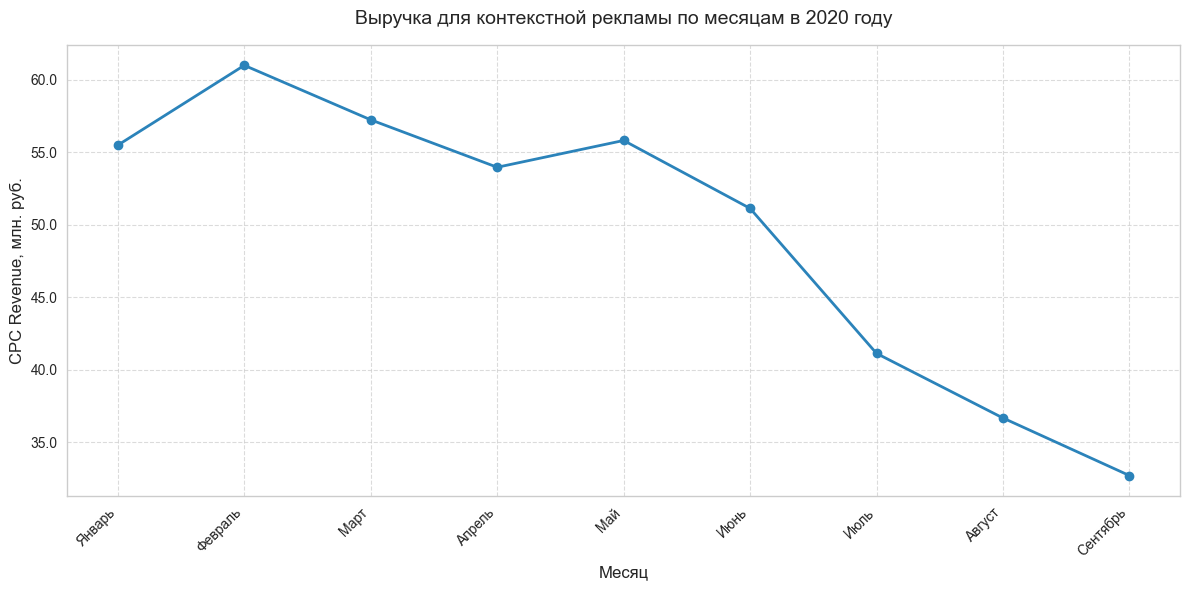

In [210]:
plt.figure(figsize=(12, 6))
plt.plot(cpc_rev_month.index, cpc_rev_month.values, 
         marker='o',
         linestyle='-',
         color='#2b83ba',
         linewidth=2)

plt.xticks(range(1, 10), [month_dict[i] for i in range(1, 10)], 
          rotation=45,
          ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

plt.title('Выручка для контекстной рекламы по месяцам в 2020 году', fontsize=14, pad=15)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('CPC Revenue, млн. руб.', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

Видим, что выручка от контекстной рекламы для интернет-магазина сильно сократилась к октябрю. Особенно это заметно из графика для выручки по месяцам.

Теперь же надо построить прогноз на следующие полгода. Для этого используем модель прогнозирования временных рядов Prophet

Prophet — это модель прогнозирования временных рядов, которая раскладывает данные на тренд, сезонность (годовую, недельную, дневную) и праздничные эффекты. Она автоматически подбирает параметры и хорошо работает с пропусками и аномалиями.
Мы будем её использовать потому, что она требует минимум настроек, она автоматически определяет сезонность. Также она сможет учесть ковидный эффект, праздники (например, Новый год) и точки изменения тренда.
Подходит для твоих данных: у тебя есть недельная и годовая сезонность, ковидный эффект и аномалии, с которыми Prophet справляется лучше, чем ARIMA или регрессия.

In [266]:
rev_day = pd.DataFrame({"ds" : cpc_rev_day.index, "y" : cpc_rev_day["revenue"]})
prophet_data = rev_day.reset_index(drop=True)
prophet_data.head()

,ds,y
0,2020-01-01,1278862.0
1,2020-01-02,1774136.0
2,2020-01-03,1889112.0
3,2020-01-04,2072428.0
4,2020-01-05,2061834.0


In [267]:
prophet_data['is_covid'] = (prophet_data['ds'] >= datetime(2020, 3, 30)).astype(int)

In [268]:
from prophet import Prophet
model = Prophet()
model.add_regressor('is_covid')
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(prophet_data)

16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing


In [269]:
future = model.make_future_dataframe(periods=180)
future['is_covid'] = 1
forecast = model.predict(future)

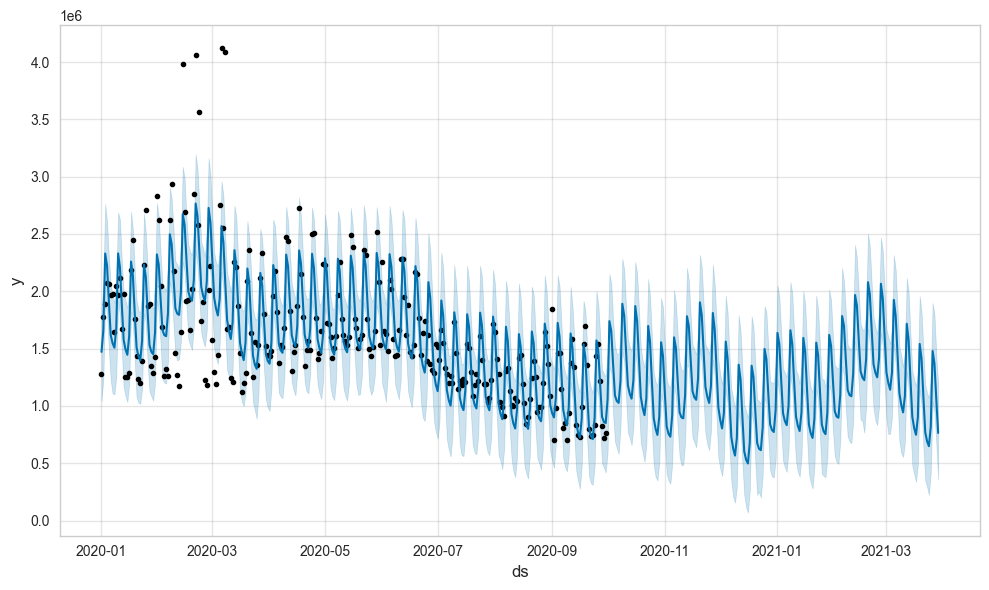

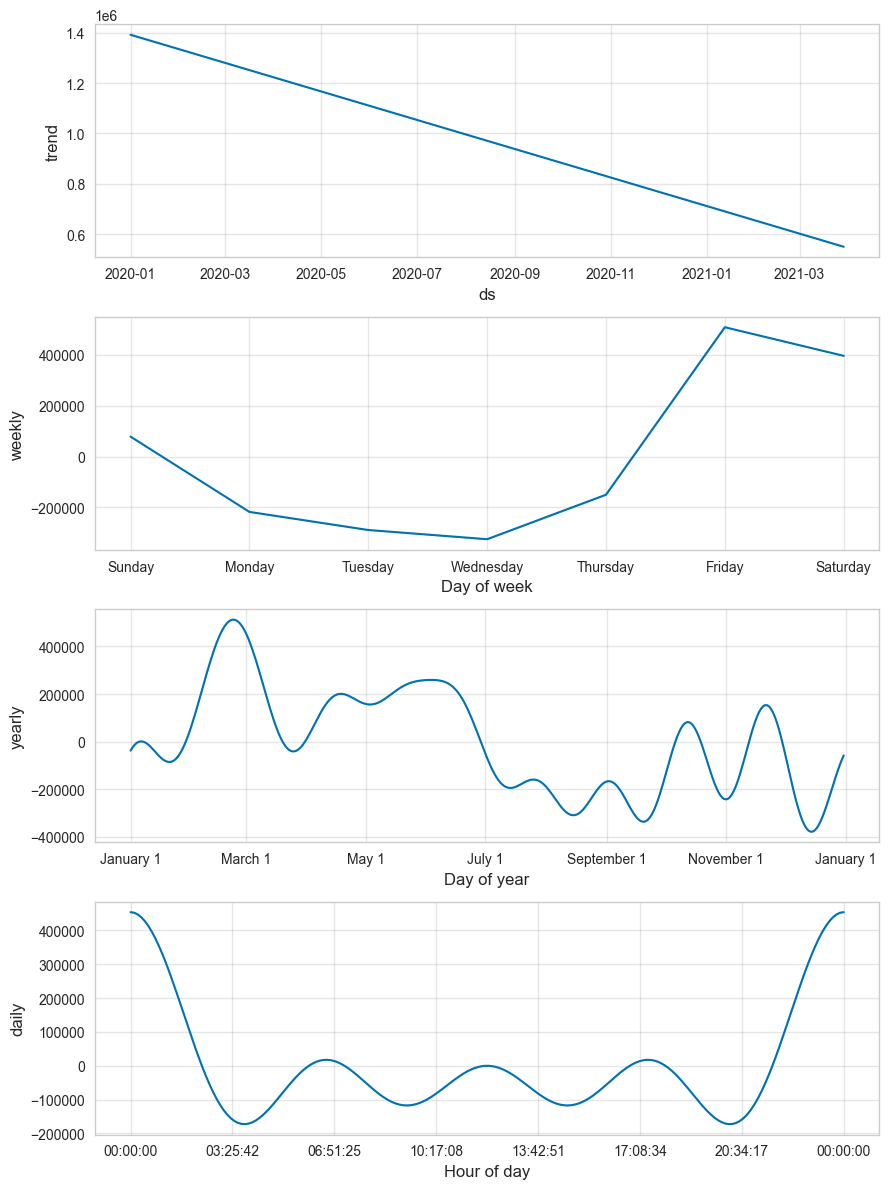

In [270]:
model.plot(forecast)
model.plot_components(forecast)
plt.show()

Таким образом по предсказанию модели Prophet можно сделать следующие выводы о характере выручки с направления контекстной рекламы на следующие полгода: 
- Продолжит сохраняться сильная недельная сезонность: доход выше в конце недели (пятница), ниже в начале (понедельник).
- Сохранится общий тренд — снижение дохода с 1.4 млн в начале 2020 до 0.6 млн к марту 2021.
- Ковидный эффект (с апреля 2020) не вызвал резкого изменения тренда, но увеличил волатильность. Это говорит о том, что ковид, скорее всего, повлиял на краткосрочные колебания (например, из-за изменения поведения пользователей), но не изменил долгосрочный тренд на сокращение доходов от контекстной рекламы.

---